In [2]:
# imports

import datetime
import numpy as np
import pandas as pd
import os
from os import listdir
from datetime import date
import matplotlib.pyplot as plt
from os.path import isfile, join

In [3]:
# Toplevel log file directories

gsi_log_dir = "/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs"
troxel_log_dir = "/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing"
troxel_master = "/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/TAMU_112419_Gemini.csv"

In [8]:
# get all the experiment log directories

def get_exp_dirs( gsi_log_dir, troxel_log_dir):
    
    all_dirs = []
    gsi_exp_dirs = [ "RUN1_ARGON_LET6.7_", "RUN2_LET6.7", "RUN3_LET6.7", "RUN4_LET6.7", \
                    "RUN5_LET6.7", "RUN6_LET6.7", "RUN7_LET6.7", "RUN8_LET17", \
                    "RUN9_FUNCTIONALCHECK", "RUN10_LET26.6", "RUN11_LET26.6", \
                    "RUN12_LET37", "RUN13_FUNCTIONALCHECK", "RUN14_LET37_TEMP80", \
                    "RUN15_FUNCTIONALCHECK", "RUN16_LET53.4", "RUN17_FUNCTIONALCHECK", \
                    "RUN18_LET60", "RUN19_FUNCTIONALCHECK" ]
    for i in range(19):
        gsi_exp_dir = os.path.join( gsi_log_dir, gsi_exp_dirs[i] )
        troxel_exp_dir = os.path.join( troxel_log_dir, "Run_%d" % (i+1)  )
        fname = "Run %d" % ( i + 1 )
        all_dirs.append( ( gsi_exp_dir, troxel_exp_dir, fname ) )
    
    return all_dirs
    
all_dirs = get_exp_dirs( gsi_log_dir, troxel_log_dir )
print(len(all_dirs))

19


In [10]:
# locate search logging file and produce dataframes

def get_search_log_df(gsi_exp_dir):
    files = [f for f in listdir(gsi_exp_dir) if isfile(join(gsi_exp_dir, f))]
    for i in range(len(files)):
        if files[i][0:6] == 'SEARCH':
            file = files[i]
            break
    file = gsi_exp_dir + '/' + file
    with open(file) as f:
        content = f.readlines()
    content = [x.strip() for x in content] 

    # get time data
    for i in range(len(content)):
        if content[i][0:4] == '2019':
            content = content[i:]
            break
        
    # break time-stamped data into a multi-dimensional array        
    search = []        
    for i in range(len(content)):
        temp = content[i].split()
        try:
            date_time_str = temp[0] + ' ' + temp[1]
            date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')
        except:
            print("ERROR PARSING LINE IN FILE", temp)
            break
        date = date_time_obj.date()
        time = date_time_obj.time()
        col3 = ''
        for i in range(len(temp[2:])):
            col3 = col3 + temp[i+2] + ' '
        col3 = col3[:-1]
        item = [date_time_obj, date, time, col3]
        search.append(item)

    # create pandas dataframe with time-stamped data
    df = pd.DataFrame(search) 
    #df.head(10)
    return df

all_dfs = []
for i in range(len(all_dirs)):
    gsi_exp_dir = all_dirs[i][0]
    print(gsi_exp_dir)
    df = get_search_log_df( gsi_exp_dir )
    all_dfs.append(df)
    
print(len(all_dfs), len(all_dirs))

/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN1_ARGON_LET6.7_
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN2_LET6.7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN3_LET6.7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN4_LET6.7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN5_LET6.7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN6_LET6.7
ERROR PARSING LINE IN FILE ['terminate', 'arc']
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN7_LET6.7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN8_LET17
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN9_FUNCTIONALCHECK
ERROR PARSING LINE IN FILE ['\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [83]:
# locate minidom logging file and produce dataframes

import re

print(len(all_dirs))
def get_minicom_log_data(gsi_exp_dir):
    files = [f for f in listdir(gsi_exp_dir) if isfile(join(gsi_exp_dir, f))]
    #print(files)
    for i in range(len(files)):
        if files[i].startswith('PCDMINICOM'):
            file = files[i]
            break
    filepath = gsi_exp_dir + '/' + file
    with open(filepath) as f:
        content = f.readlines()
    content = [x.strip() for x in content] 
        
    regex = re.compile("\[\s*(\d*.\d*)\](.*)")
    
    items = []
    for ln in content:
        matches = regex.match(ln)
        if matches==None or len(matches.groups())!=2:
            print("Could not match line->", ln)
            continue
        #print(matches)
        ts = float( matches.groups()[0])
        msg = matches.groups()[1]
        item = [ts, msg]
        #print(item)
        items.append(item)

    # create pandas dataframe with time-stamped data
    df = pd.DataFrame(items) 
    
    # now get the diff time between board and pc
    fileparts = file.split("--")
    
    pcts = fileparts[1].replace("_"," ")
    boardts = fileparts[2].replace("_"," ")
    
    #pcts = "Mon Nov 25 00:17:20 IST 2019"
    #boardts = "Sun Nov 24 21:52:30 UTC 2019"
    
    pc_parts = pcts.split()
    board_parts = boardts.split()
    
    pc_month = [ "none", "Jan", "Feb", "Mar", "Apr", "May", "June", \
             "July", "Aug", "Sept", "Oct", "Nov", "Dec" ].index( pc_parts[1])
    board_month = [ "none", "Jan", "Feb", "Mar", "Apr", "May", "June", \
             "July", "Aug", "Sept", "Oct", "Nov", "Dec" ].index( board_parts[1])
    
    new_pc_ts = "%s-%s-%s %s" % ( pc_parts[-1], pc_month, pc_parts[2], pc_parts[3] )
    new_board_ts = "%s-%s-%s %s" % ( board_parts[-1], board_month, board_parts[2], board_parts[3] )
    
    new_pc_time_obj = datetime.datetime.strptime(new_pc_ts, '%Y-%m-%d %H:%M:%S')
    new_board_time_obj = datetime.datetime.strptime(new_board_ts, '%Y-%m-%d %H:%M:%S')
    
    diff_time =  new_pc_time_obj - new_board_time_obj
    print(diff_time, new_pc_time_obj)

    #df.head(10)
    return [ df, diff_time, new_pc_time_obj ]

#gsi_exp_dir = all_dirs[1][0]
#get_minidom_log_df( gsi_exp_dir )

all_minicom_data = []
for i in range(len(all_dirs)):
    gsi_exp_dir = all_dirs[i][0]
    #print(gsi_exp_dir)
    data = get_minicom_log_data( gsi_exp_dir )
    all_minicom_data.append(data)
    
print(len(all_minicom_data), len(all_dirs))

19
2:24:37 2019-11-24 19:37:40
2:24:40 2019-11-24 20:07:13
2:24:41 2019-11-24 20:12:58
2:24:41 2019-11-24 20:19:30
2:24:43 2019-11-24 20:23:46
2:24:44 2019-11-24 20:33:46
2:24:44 2019-11-24 20:35:41
2:24:45 2019-11-24 20:43:21
2:24:46 2019-11-24 20:51:58
2:24:46 2019-11-24 21:56:29
2:24:47 2019-11-24 22:22:34
2:24:47 2019-11-24 22:26:02
2:24:48 2019-11-24 22:33:54
2:24:47 2019-11-24 22:52:08
2:24:48 2019-11-24 22:58:20
2:24:49 2019-11-24 23:54:55
2:24:48 2019-11-25 00:14:10
Could not match line-> 
Could not match line-> root@se120_v3116-600mhz:~#
Could not match line-> root@se120_v3116-600mhz:~#
2:24:50 2019-11-25 00:17:20
2:24:50 2019-11-25 00:54:12
19 19


In [45]:
# Parse the power log files and produce dataframes

def get_power_df( troxel_exp_dir ):
    troxel_test_file = os.path.join( troxel_exp_dir, '2 E36313A 192.168.10.10.CSV' )
    try:
        troxel_data = pd.read_csv(troxel_test_file) 
    except:
        print("Could not parse", troxel_test_file)
        return None
    troxel_data = troxel_data.iloc[8:]
    troxel_data.rename(columns={"Address": "Time (s)", "TCPIP0::192.168.10.10::5025::SOCKET": "I2 (DC Current)", "Unnamed: 2": "V2 (DC Volt)"}, inplace = True)
    troxel_data.head(10)
    return troxel_data

all_troxel_data = []
for i in range(len(all_dirs)):
    troxel_exp_dir = all_dirs[i][1]
    print(troxel_exp_dir)
    troxel_data = get_power_df( troxel_exp_dir )
    all_troxel_data.append( troxel_data ) 

/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_1
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_2
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_3
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_4
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_5
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_6
Could not parse /Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_6/2 E36313A 192.168.10.10.CSV
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_8
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_9
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_10
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_11
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_12
/Users/gwilliams/

In [46]:
# Parse the beam log file and produce dataframes

def get_beam_df( troxel_exp_dir ):
    rf = open( os.path.join( troxel_exp_dir, '1 34972A 192.168.9.72.CSV' ) )
    lines = rf.readlines()
    rf.close()

    wf = open("/tmp/log.txt","w")

    found = False
    for ln in lines:
        if not found:
            if ln.startswith("Scan Sweep"):
                #print(found)
                found=True
            else:
                continue
            wf.write(ln)
        else:
            wf.write(ln)
    wf.close()

    troxel_data2 = pd.read_csv( "/tmp/log.txt")
    #troxel_data2 = troxel_data2.iloc[8:]
    #troxel_data.rename(columns={"Address": "Time (s)", "TCPIP0::192.168.10.10::5025::SOCKET": "I2 (DC Current)", "Unnamed: 2": "V2 (DC Volt)"}, inplace = True)
    troxel_data2.head(10)
    return troxel_data2

all_troxel_data2 = []
for i in range( len(all_dirs ) ):
    troxel_exp_dir = all_dirs[i][1]
    try:
        troxel_data2 = get_beam_df( troxel_exp_dir )
        all_troxel_data2.append( troxel_data2 )
    except:
        print("Could not get df for ", troxel_exp_dir, i)
        all_troxel_data2.append(None)
        
print( len(all_troxel_data2 ))

Could not get df for  /Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_6 5
Could not get df for  /Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_13 12
19


In [47]:
# match time stamps across experiments and produce a ts diff

def get_gsi_troxel_diff():
    gsi_pc_ts = "Sun Nov 24 17:56:19 IST 2019"
    troxel_ts = "2019-11-24 09:56:24.037937"

    troxel_time_obj = datetime.datetime.strptime(troxel_ts, '%Y-%m-%d %H:%M:%S.%f')

    # re-orient fields in gsi ts
    parts = gsi_pc_ts.split()
    #print(parts)
    #day = ["Sun","Mon","Tue","Wed","Thurs","Fri","Sat"].indexof(parts[0])
    month = [ "none", "Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec" ].index( parts[1])
    new_ts = "%s-%s-%s %s" % ( parts[-1], month, parts[2], parts[3] )
    #print(new_ts)

    gsi_time_obj = datetime.datetime.strptime(new_ts, '%Y-%m-%d %H:%M:%S')

    diff_time = gsi_time_obj - troxel_time_obj
    print(diff_time)
    return diff_time

def get_gsi_pc_board_diff():
    
    pcts = "Mon Nov 25 00:17:20 IST 2019"
    boardts = "Sun Nov 24 21:52:30 UTC 2019"
    
    pc_parts = pcts.split()
    board_parts = boardts.split()
    
    pc_month = [ "none", "Jan", "Feb", "Mar", "Apr", "May", "June", \
             "July", "Aug", "Sept", "Oct", "Nov", "Dec" ].index( pc_parts[1])
    board_month = [ "none", "Jan", "Feb", "Mar", "Apr", "May", "June", \
             "July", "Aug", "Sept", "Oct", "Nov", "Dec" ].index( board_parts[1])
    
    new_pc_ts = "%s-%s-%s %s" % ( pc_parts[-1], pc_month, pc_parts[2], pc_parts[3] )
    new_board_ts = "%s-%s-%s %s" % ( board_parts[-1], board_month, board_parts[2], board_parts[3] )
    
    new_pc_time_obj = datetime.datetime.strptime(new_pc_ts, '%Y-%m-%d %H:%M:%S')
    new_board_time_obj = datetime.datetime.strptime(new_board_ts, '%Y-%m-%d %H:%M:%S')
    
    diff_time =  new_pc_time_obj - new_board_time_obj
    print(diff_time)

diff_time = get_gsi_troxel_diff()

board_diff_time = get_gsi_pc_board_diff()

7:59:54.962063
2:24:50


In [95]:
# adjust all logs relative to GSI time...

import sys

def adjust_ts(run, df, troxel_data, troxel_data2, minicom_data):
    
    print("Adjusting for run ", run+1)
    
    # adjust the board voltage and current time
    
    #print(troxel_data.columns)
    orig_date_col = troxel_data["Time (s)"]
    #print(type(orig_date_col))
    shape = orig_date_col.shape
    #print(shape[0])
    ts = []
    dt_list = list( orig_date_col )
    #dt_list[0]
    for i in range(shape[0]):
        dtobj = datetime.datetime.strptime( dt_list[i], '%Y-%m-%d %H:%M:%S.%f')
        dtobj = dtobj + diff_time
        ts.append(dtobj)
    #print(ts)
    troxel_data["newts"] = ts
    troxel_data.head(10)
    #print(troxel_data.columns)

    # adjust the beam voltage time

    #print(troxel_data2.columns)
    orig_date_col = troxel_data2["102Time (Sec)"]
    #print(type(orig_date_col))
    shape = orig_date_col.shape
    #print(shape[0])
    ts = []
    dt_list = list( orig_date_col )
    #dt_list[0]
    for i in range(shape[0]):
        dtobj = datetime.datetime.strptime( dt_list[i], '%Y-%m-%d %H:%M:%S.%f')
        dtobj = dtobj + diff_time
        ts.append(dtobj)
    #print(ts)
    troxel_data2["boardvoltage_newts"] = ts
    #troxel_data2.head(10)

    # adjust the temperature time

    #print(troxel_data2.columns)
    orig_date_col = troxel_data2["101Time (Sec)"]
    #print(type(orig_date_col))
    shape = orig_date_col.shape
    #print(shape[0])
    ts = []
    dt_list = list( orig_date_col )
    #dt_list[0]
    for i in range(shape[0]):
        dtobj = datetime.datetime.strptime( dt_list[i], '%Y-%m-%d %H:%M:%S.%f')
        dtobj = dtobj + diff_time
        ts.append(dtobj)
    #print(ts)
    troxel_data2["temp_newts"] = ts
    #troxel_data2.head(10)
    
    # adjust the minicom time
    
    minicom_df = minicom_data[0]
    minicom_diff = minicom_data[1]
    pc_time = minicom_data[2]
    
    orig_offsets_col = minicom_df[0] 
    shape = orig_offsets_col.shape
    ts = []
    offset_list = list( orig_offsets_col )
    first = offset_list[0]
    for offset in offset_list:
        dtobj = pc_time + datetime.timedelta(seconds=(offset-first))
        ts.append(dtobj)
    minicom_df["newts"] = ts

for i in range(len(all_dirs)):
    try:
        pass
        df = all_dfs[i]
        troxel_data = all_troxel_data[i]
        troxel_data2 = all_troxel_data2[i]
        #print(len(all_minicom_dfs))
        minicom_data = all_minicom_data[i]
        adjust_ts( i, df, troxel_data, troxel_data2, minicom_data )
    except:
        print("Could not adjust ts for Run ", i+1)
        print(sys.exc_info()[0], sys.exc_info()[1], sys.exc_info()[2])

Adjusting for run  1
Adjusting for run  2
Adjusting for run  3
Adjusting for run  4
Adjusting for run  5
Adjusting for run  6
Could not adjust ts for Run  6
<class 'TypeError'> 'NoneType' object is not subscriptable <traceback object at 0x11c977910>
Adjusting for run  7
Adjusting for run  8
Adjusting for run  9
Adjusting for run  10
Adjusting for run  11
Adjusting for run  12
Adjusting for run  13
Could not adjust ts for Run  13
<class 'TypeError'> 'NoneType' object is not subscriptable <traceback object at 0x11f4d0690>
Adjusting for run  14
Adjusting for run  15
Adjusting for run  16
Adjusting for run  17
Adjusting for run  18
Adjusting for run  19


In [125]:
troxel_beamvoltage_ts = list(troxel_data2["boardvoltage_newts"])
beam_voltages = list( troxel_data2["102 (Vdc)"] )


print(troxel_data2.shape)
print(len(troxel_beamvoltage_ts), len(beam_voltages))
troxel_data2.head(10)

(295, 17)
295 295


,Scan Sweep Time (Sec),Scan Number,101Time (Sec),101 (°C),102Time (Sec),102 (Vdc),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,boardvoltage_newts,temp_newts
0,2019-11-24 16:53:28.523,1,2019-11-24 16:53:28.523,59.555,2019-11-24 16:53:28.564,0.001931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:23.526063,2019-11-25 00:53:23.485063
1,2019-11-24 16:53:29.041,2,2019-11-24 16:53:29.041,59.432,2019-11-24 16:53:29.082,0.001903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:24.044063,2019-11-25 00:53:24.003063
2,2019-11-24 16:53:29.507,3,2019-11-24 16:53:29.507,59.347,2019-11-24 16:53:29.548,0.001941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:24.510063,2019-11-25 00:53:24.469063
3,2019-11-24 16:53:30.026,4,2019-11-24 16:53:30.026,59.233,2019-11-24 16:53:30.067,0.001922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:25.029063,2019-11-25 00:53:24.988063
4,2019-11-24 16:53:30.546,5,2019-11-24 16:53:30.546,59.139,2019-11-24 16:53:30.587,0.001931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:25.549063,2019-11-25 00:53:25.508063
5,2019-11-24 16:53:31.010,6,2019-11-24 16:53:31.010,59.024,2019-11-24 16:53:31.051,0.001925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:26.013063,2019-11-25 00:53:25.972063
6,2019-11-24 16:53:31.532,7,2019-11-24 16:53:31.532,58.855,2019-11-24 16:53:31.573,0.001938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:26.535063,2019-11-25 00:53:26.494063
7,2019-11-24 16:53:32.047,8,2019-11-24 16:53:32.047,58.783,2019-11-24 16:53:32.088,0.001923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:27.050063,2019-11-25 00:53:27.009063
8,2019-11-24 16:53:32.515,9,2019-11-24 16:53:32.515,58.650,2019-11-24 16:53:32.556,0.001942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:27.518063,2019-11-25 00:53:27.477063
9,2019-11-24 16:53:33.032,10,2019-11-24 16:53:33.032,58.533,2019-11-24 16:53:33.073,0.001916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:28.035063,2019-11-25 00:53:27.994063


In [131]:
# produce all data for plotting

#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

def prep_plot_data(df, troxel_data, troxel_data2, minicom_data):
    
    gsi_ts = list(df[0])
    #print(type(gsi_ts[0]),gsi_ts[0], len(gsi_ts))

    logs = list(df[3])
    #print( type(logs[0]), logs[0], len(logs))

    logs_marker = [ ]
    for log in logs:
        if log.find("knn_hamming")>=0:
            logs_marker.append(0)
        elif log.find("duration")>=0:
            logs_marker.append(1)
    #    elif log.find("gnl")>=0:
    #        print("log==",log)
    #        logs_marker.append("-1")
        else:
            #print("log==",log)
            logs_marker.append(-1)

    #print(troxel_data.columns)
    troxel_ts = list(troxel_data["newts"])
    #print( "troxel_ts", type(troxel_ts[0]), troxel_ts[0], len(troxel_ts))

    voltages = list(troxel_data["V2 (DC Volt)"])
    #print( "voltages", type(voltages[0]), voltages[0], len(voltages))
    voltages = [ float(v) for v in voltages ]

    current = list(troxel_data["I2 (DC Current)"])
    current = [ float(c) for c in current ]
    #print( "current", type(current[0]), current[0], len(current))

    troxel_beamvoltage_ts = list(troxel_data2["boardvoltage_newts"])
    beam_voltages = list( troxel_data2["102 (Vdc)"] )
    #print("dbg",len(beam_voltages), len(troxel_beamvoltage_ts) )
    beam_voltages = [ float(v) for v in beam_voltages ]
    #print( "beam info", type(beam_voltages), beam_voltages[0], len(beam_voltages), len(troxel_beamvoltage_ts) )
    
    # look for beam on extents
    thresh=2
    beam_ons = []
    #print("bv",len(beam_voltages), len(troxel_beamvoltage_ts))
    prev = beam_voltages[0]
    for idx, v in enumerate(beam_voltages):
        if idx==0: continue
        if prev<2 and v>2: 
            #print("leading edge")
            beam_ons.append([ troxel_beamvoltage_ts[idx], None ] )
        elif prev>2 and v<2:
            #print("trailing edge")
            #print("beam_ons",beam_ons[-1], troxel_beamvoltage_ts[idx])
            beam_ons[-1][1] = troxel_beamvoltage_ts[idx]
            print("beam_ons",beam_ons)
            
        prev = v
        

    troxel_temp_ts = list(troxel_data2["temp_newts"])
    temps = list( troxel_data2["101 (°C)"] )
    temps = [ float(v) for v in temps ]
    #print( type(temps), temps[0], len(temps), len(troxel_temp_ts))
    
    minicom_df = minicom_data[0]
    minicom_ts = list(minicom_df["newts"])
    logs = list( minicom_df[1])
    minicom_markers = []
    for log in logs:
        if log.find("ALTS Warning")>=0:
            minicom_markers.append(0)
        elif log.find("APU GPO Event")>=0:
            minicom_markers.append(1)
        elif log.find("data parity error")>=0:
            minicom_markers.append(2)
        elif log.find("address parity error")>=0:
            minicom_markers.append(3)
        else:
            minicom_markers.append(-1)
    
    return gsi_ts, logs, logs_marker, troxel_ts, voltages, current, \
            troxel_beamvoltage_ts, beam_voltages, troxel_temp_ts, temps, \
            minicom_ts, minicom_markers, beam_ons

all_gsi_ts = []
all_logs = []
all_logs_marker = []
all_troxel_ts = []
all_voltages = []
all_current = []
all_troxel_beamvoltages_ts = []
all_beam_voltages = []
all_troxel_temp_ts = []
all_temps = []
all_minicom_ts = []
all_minicom_markers = []
all_beam_ons = []

for i in range(len(all_dirs)):
    
    try:
        gsi_ts, logs, logs_marker, troxel_ts, voltages, \
        current, troxel_beamvoltages_ts, beam_voltages, \
        troxel_temp_ts, temps, minicom_ts, minicom_markers, beam_ons = \
            prep_plot_data( all_dfs[i], all_troxel_data[i], all_troxel_data2[i], all_minicom_data[i] )

        all_gsi_ts.append( gsi_ts )
        all_logs.append( logs )
        all_logs_marker.append( logs_marker )
        all_troxel_ts.append( troxel_ts )
        all_voltages.append( voltages )
        all_current.append( current )
        all_troxel_beamvoltages_ts.append( troxel_beamvoltages_ts )
        all_beam_voltages.append( beam_voltages )
        all_troxel_temp_ts.append( troxel_temp_ts)
        all_temps.append( temps )
        all_minicom_ts.append( minicom_ts)
        all_minicom_markers.append( minicom_markers )
        all_beam_ons.append( beam_ons )
        
    except:
        print("Could not get plot data for Run ", i+1)
        print(sys.exc_info()[0])
        all_gsi_ts.append( None)
        all_logs.append( None )
        all_logs_marker.append( None )
        all_troxel_ts.append( None )
        all_voltages.append( None )
        all_current.append( None )
        all_troxel_beamvoltages_ts.append( None )
        all_beam_voltages.append( None )
        all_troxel_temp_ts.append( None)
        all_temps.append( None )
        all_minicom_ts.append( None )
        all_minicom_markers.append( None )
        all_beam_ons.append( None )


beam_ons [[Timestamp('2019-11-24 19:38:18.147063'), Timestamp('2019-11-24 19:40:43.178063')]]
beam_ons [[Timestamp('2019-11-24 20:08:44.337063'), Timestamp('2019-11-24 20:10:28.359063')]]
beam_ons [[Timestamp('2019-11-24 20:13:41.934063'), Timestamp('2019-11-24 20:17:34.989063')]]
beam_ons [[Timestamp('2019-11-24 20:20:05.909063'), Timestamp('2019-11-24 20:21:12.461063')]]
beam_ons [[Timestamp('2019-11-24 20:20:05.909063'), Timestamp('2019-11-24 20:21:12.461063')], [Timestamp('2019-11-24 20:21:23.893063'), Timestamp('2019-11-24 20:21:28.965063')]]
beam_ons [[Timestamp('2019-11-24 20:24:23.439063'), Timestamp('2019-11-24 20:29:30.476063')]]
Could not get plot data for Run  6
<class 'TypeError'>
beam_ons [[Timestamp('2019-11-24 20:36:31.243063'), Timestamp('2019-11-24 20:40:17.271063')]]
beam_ons [[Timestamp('2019-11-24 20:45:55.623063'), Timestamp('2019-11-24 20:49:18.659063')]]
beam_ons [[Timestamp('2019-11-24 22:15:40.681063'), Timestamp('2019-11-24 22:19:03.211063')]]
beam_ons [[Time

In [97]:
# Load the master log file which contains Run specifics like beam, notes, etc.

import math
f = open(troxel_master)
lines = f.readlines()
f.close()

f = open("/tmp/test.txt","w")
for ln in lines[1:]:
    f.write(ln)
f.flush()
f.close()

master_df = troxel_data = pd.read_csv("/tmp/test.txt") 
#master_df.head(2)
print( master_df.columns )

expdetails = {}
expnotes = {}
for i in range(len(all_dirs)):
    rows = master_df.loc[master_df['Run number'] == (i+1)]
    #print(rows.shape)
    
    if (rows.shape[0]==1):
        selbeam = list(rows['Selected beam'])[0]
        print("-%s-"%selbeam)
        if not selbeam:
            continue
        avgflux = list(rows["Average flux (ions/(cm2s))"])[0]
        efflet = list(rows["Effective LET (MeVcm2/mg)"])[0]
        benergy = list(rows["Beam energy (MeV/amu)"])[0]
        notes = list(rows["Run Notes"])[0]
        
        if notes=="nan": 
            notes = "None"
        elif type(notes)==type(1.0) and math.isnan( notes):
            notes = "None"    
        #print("notes=",notes,type(notes))
            
        #targetmat = listrows["Target material"]
        #print(selbeam, avgflux,efflet,benergy,"")
        expdet = "beam=%s / avg flux=%s / eff LET=%s / beam E=%s" % (selbeam, avgflux,efflet, benergy)
        #print(i+1, expdet)
        expdetails[i+1]=expdet
        expnotes[i+1]=notes

Index(['Run number', 'Run file name', 'Run start date and time',
       'Run end date and time', 'Duration of the run', 'Number of events',
       'Selected beam', 'Al degrader thickness (mil)',
       'Number of layers (layer file name)', 'Beam energy (MeV/amu)',
       'Beam energy (MeV)', 'Target material', 'Nominal LET (MeVcm2/mg)',
       'Nominal range (um)', 'Effective LET (MeVcm2/mg)',
       'Effective range (um)', 'DUT location', 'Position set name',
       'Effective fluence (ions/cm2)', 'Dose (rad)', 'Live time (s)',
       'Dead time (s)', 'Average flux (ions/(cm2s))', 'Average flux error (%)',
       'Overall uniformity (%)', 'Overall central shift (%)',
       'Calibration factor', 'DUT X coordinate', 'DUT Y coordinate',
       'DUT Z coordinate', 'DUT tilt angle', 'Roll angle', 'Unused coordinate',
       'Selected Al degrader number', 'Degrader rotation angle',
       'Detector bias (V)', 'Facility', 'Beam Operator', 'Test Engineers',
       'DUT Manufacturer', 'Manufa

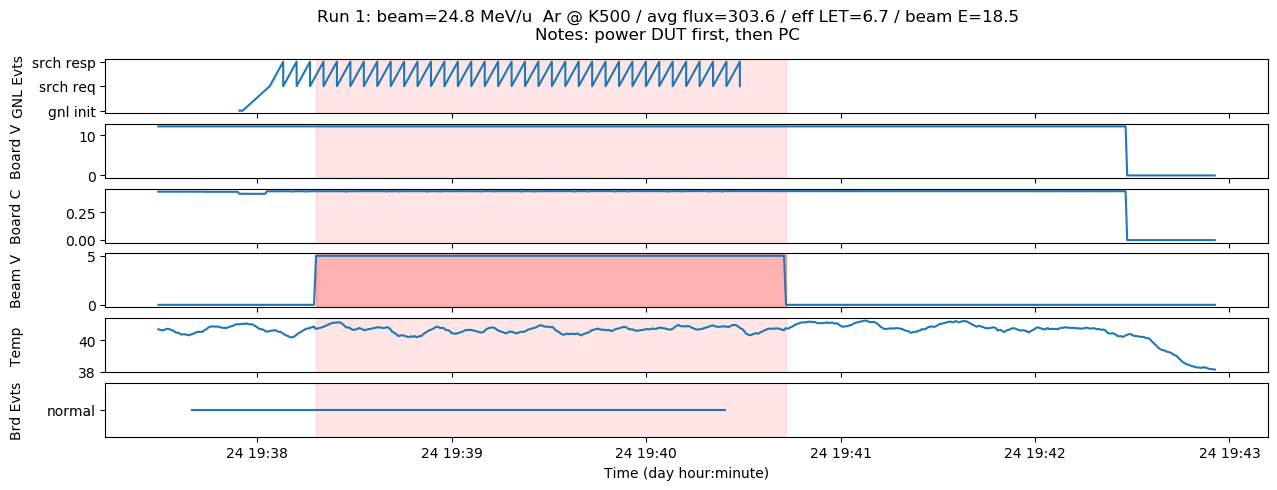

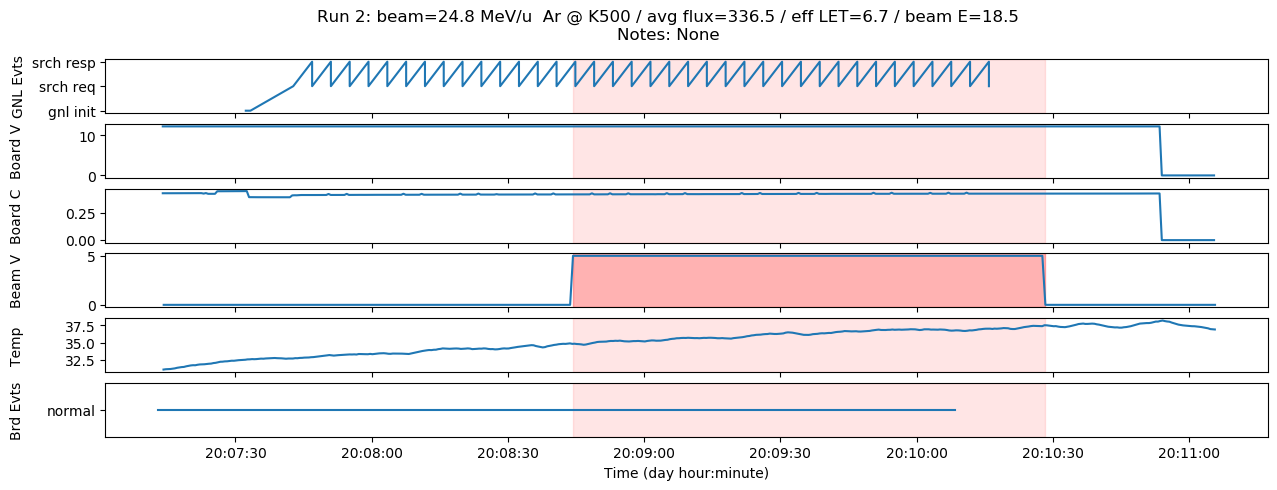

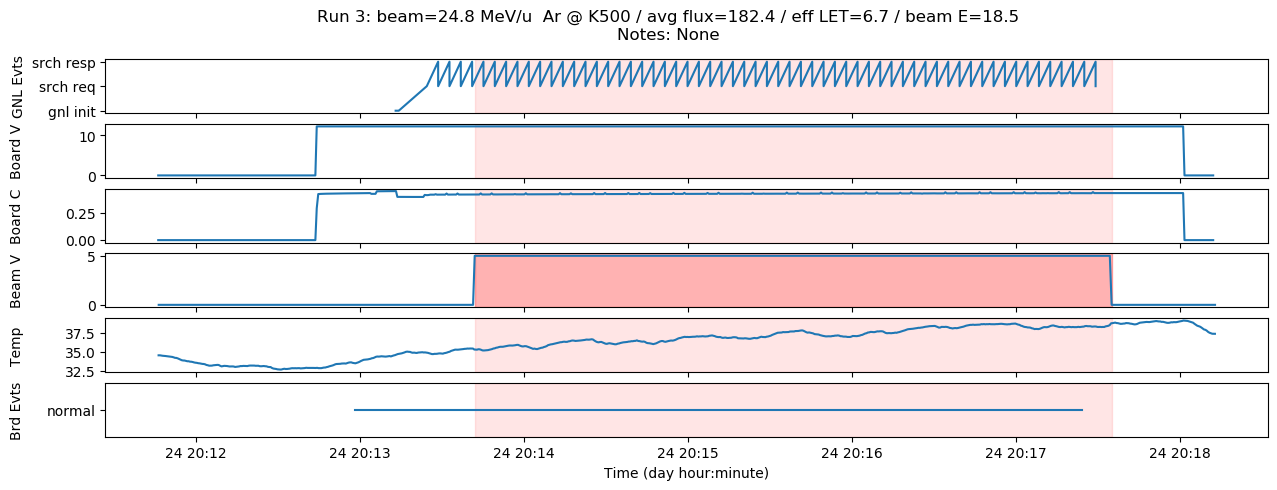

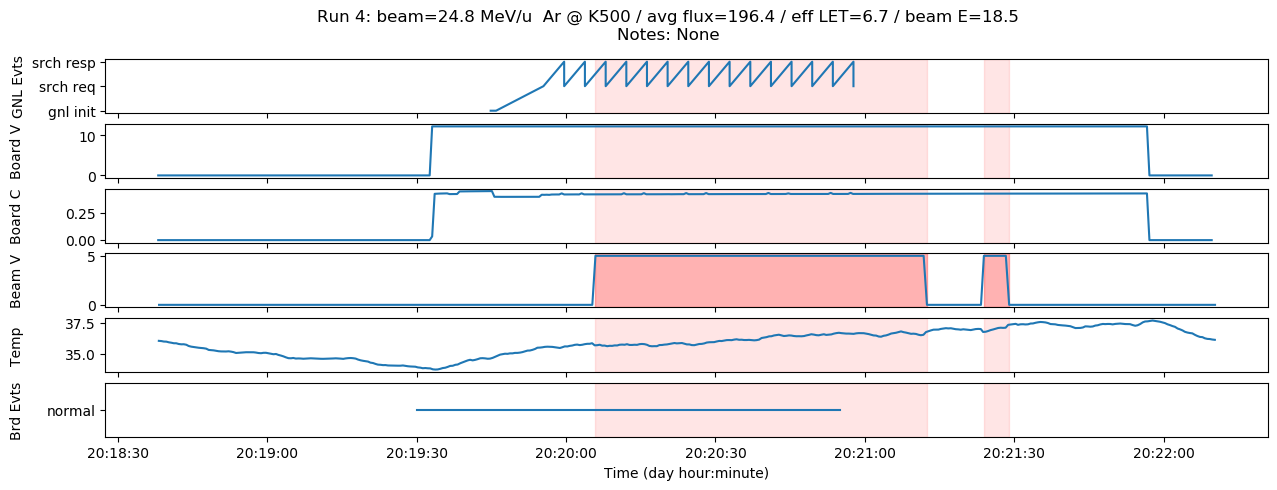

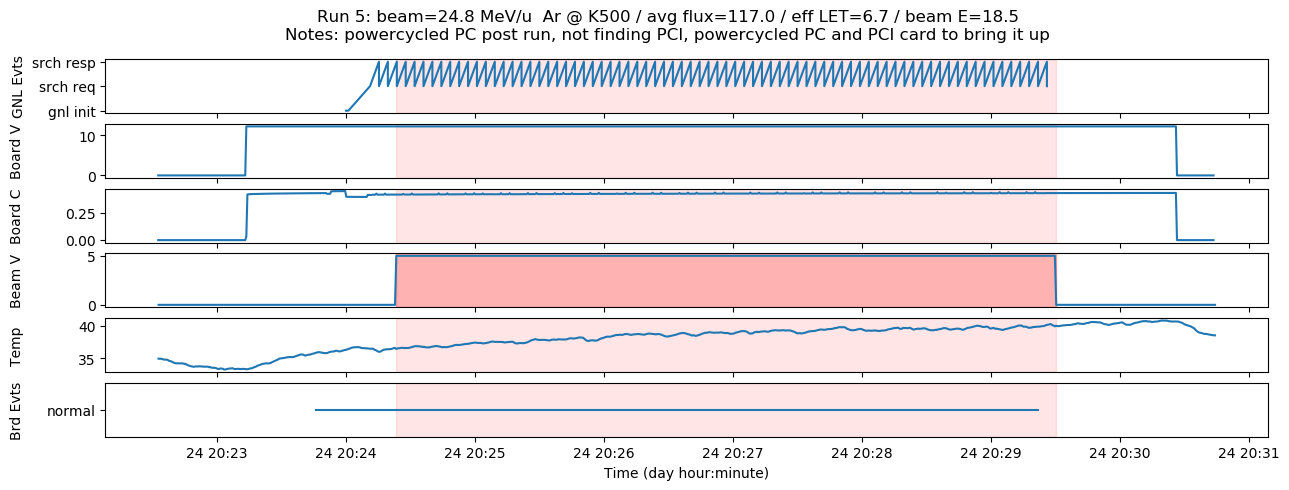

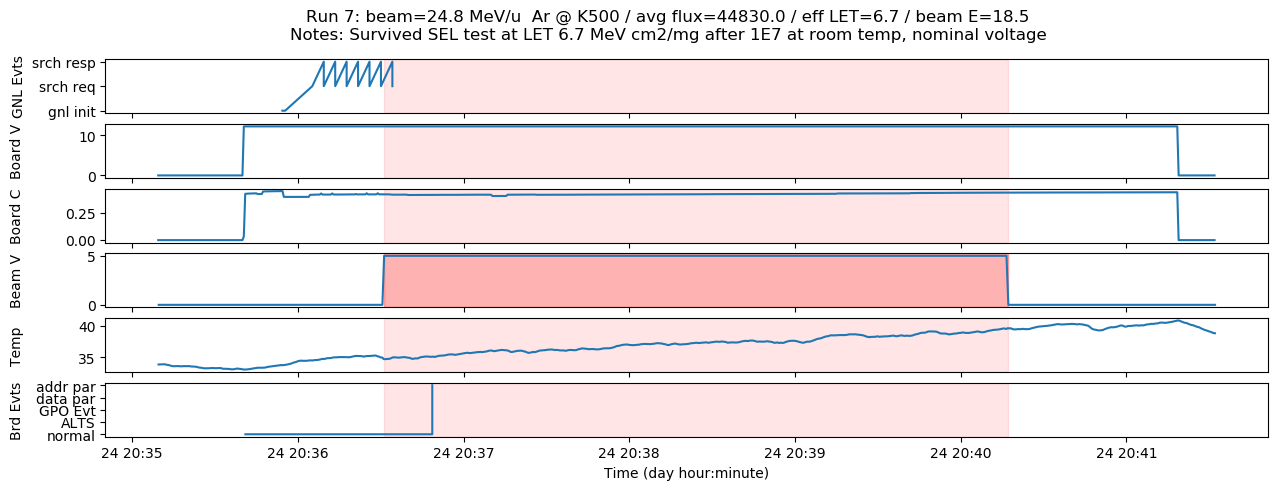

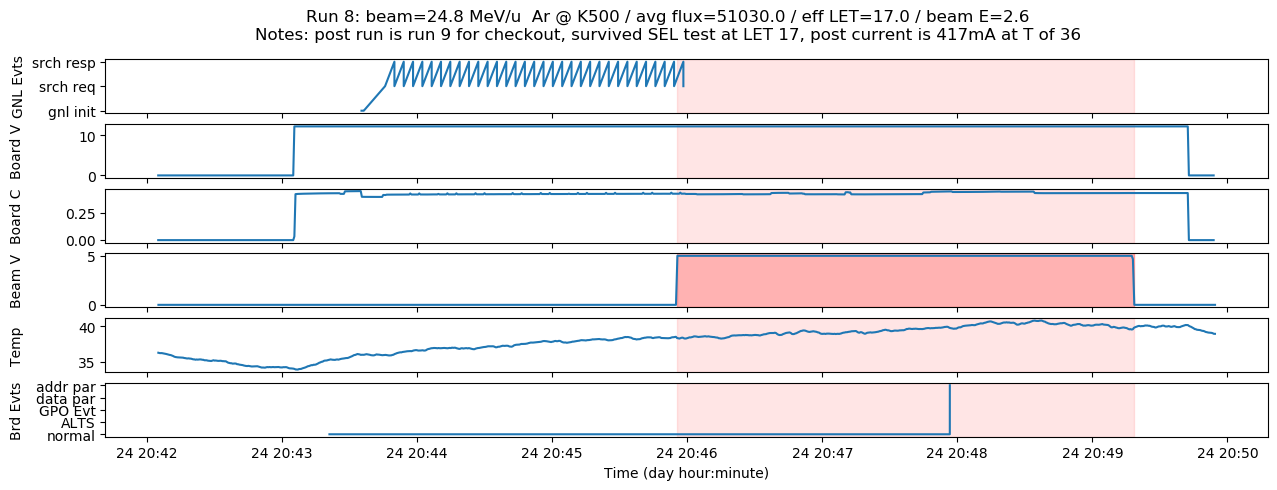

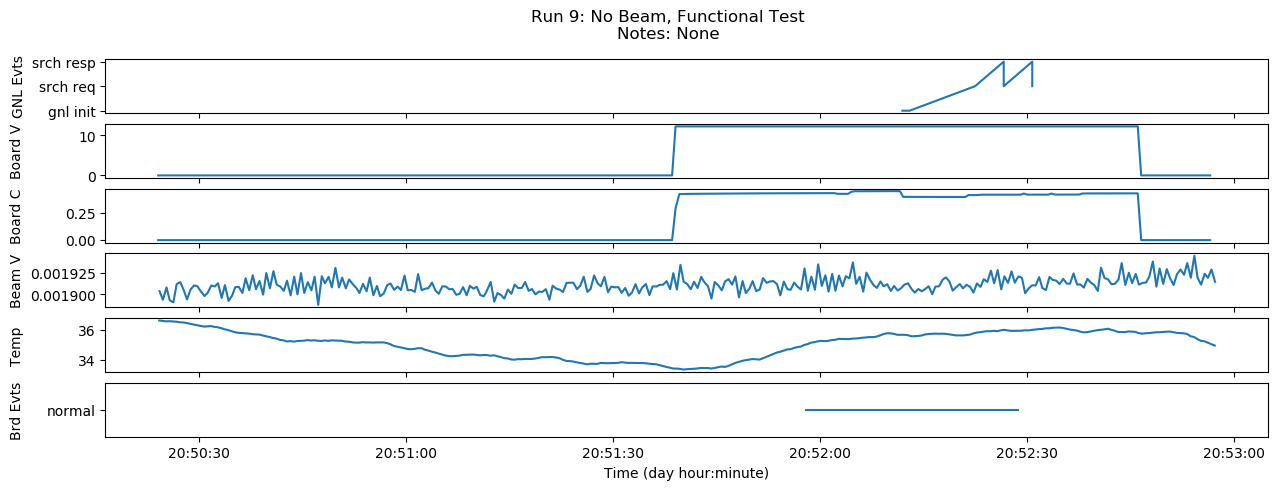

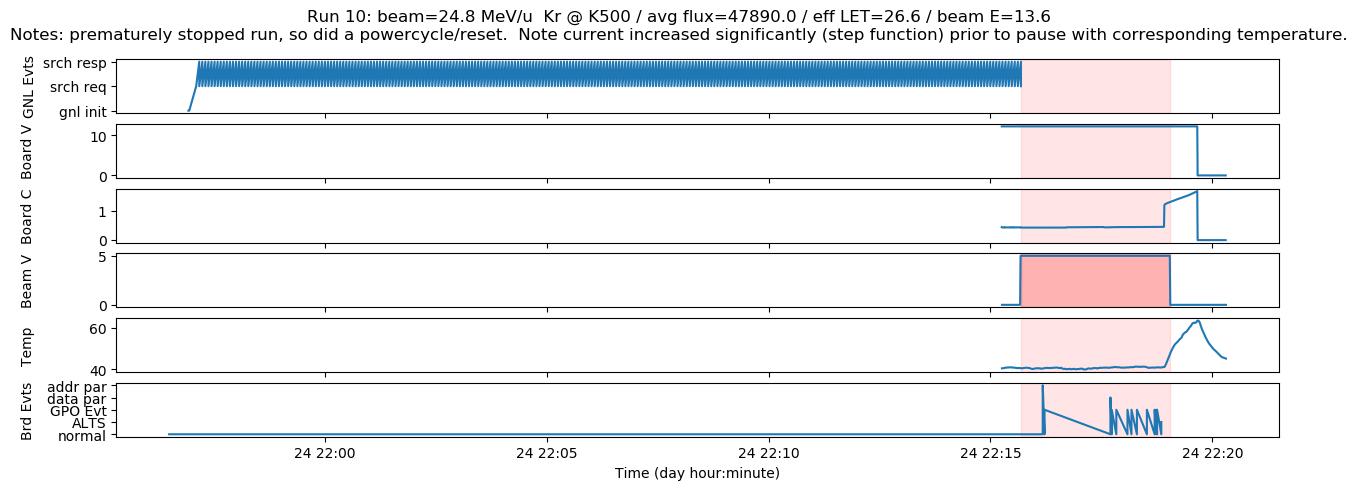

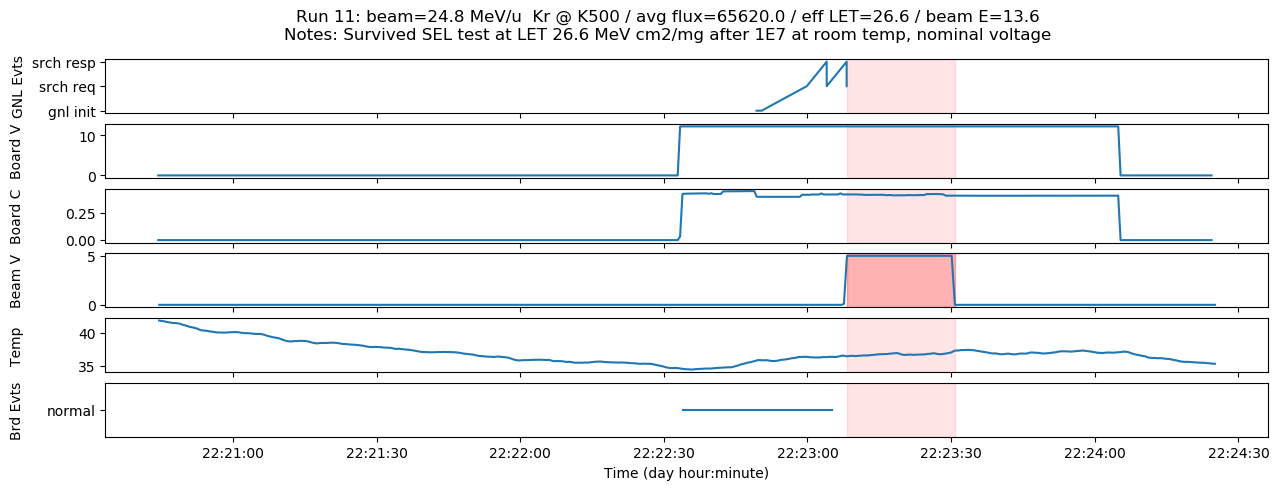

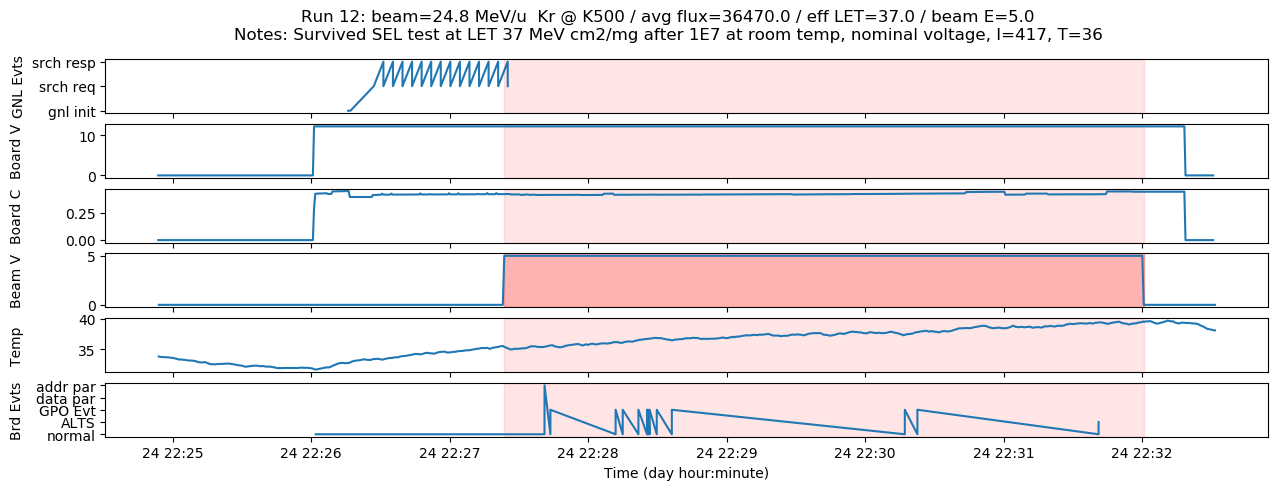

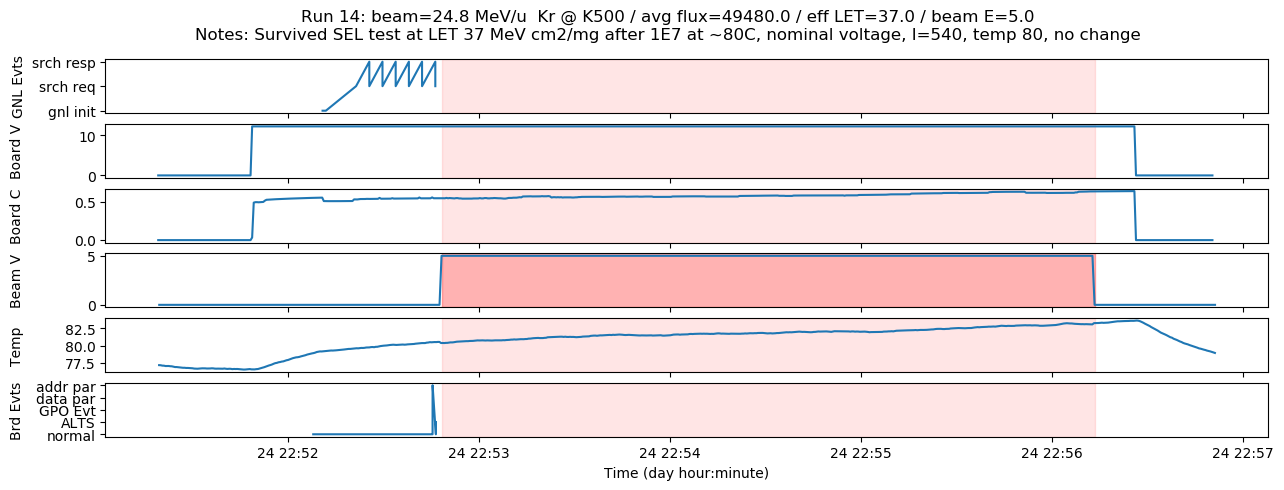

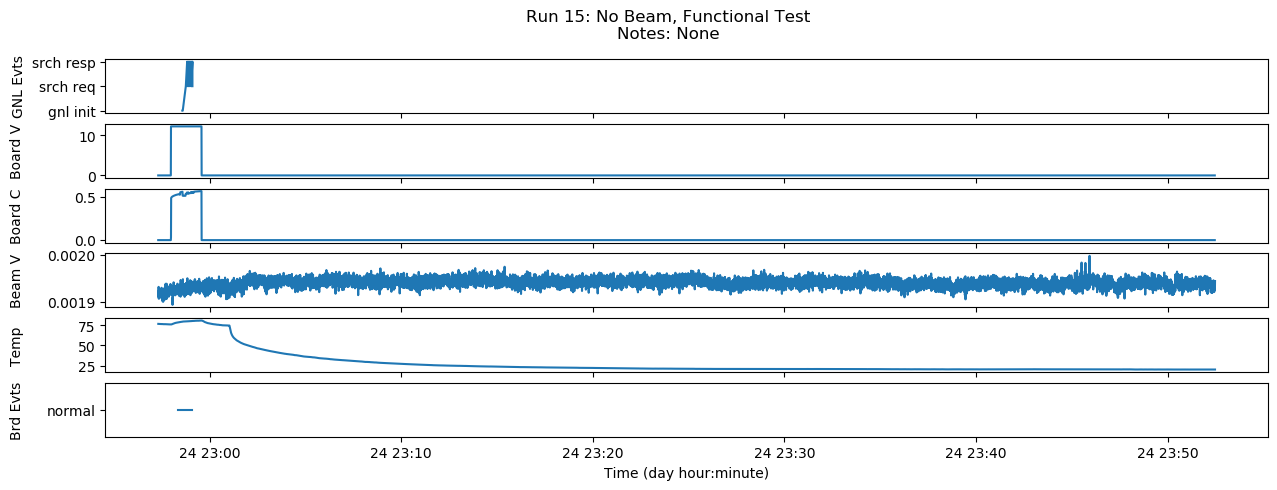

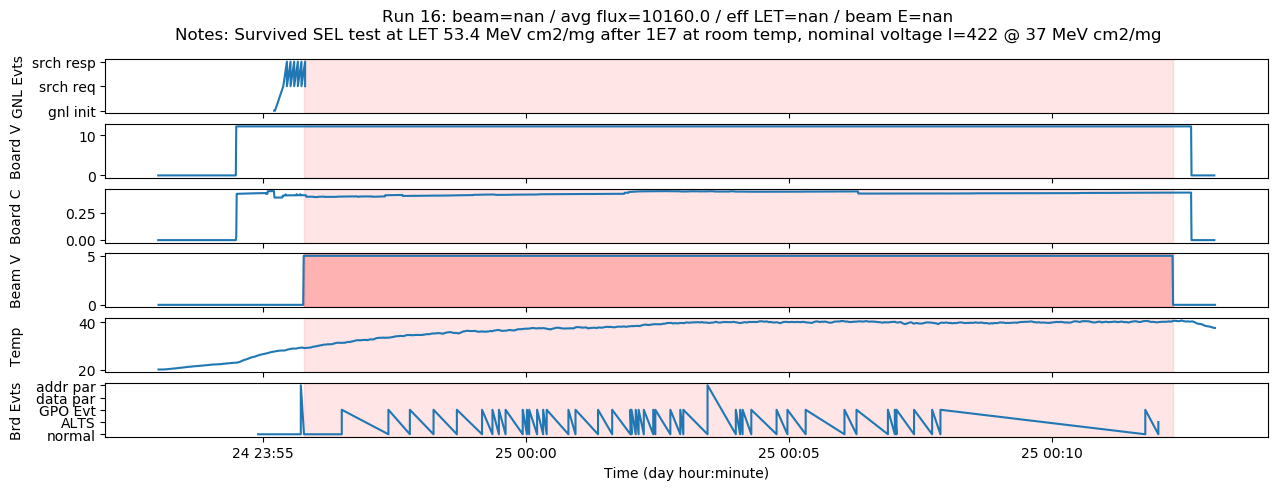

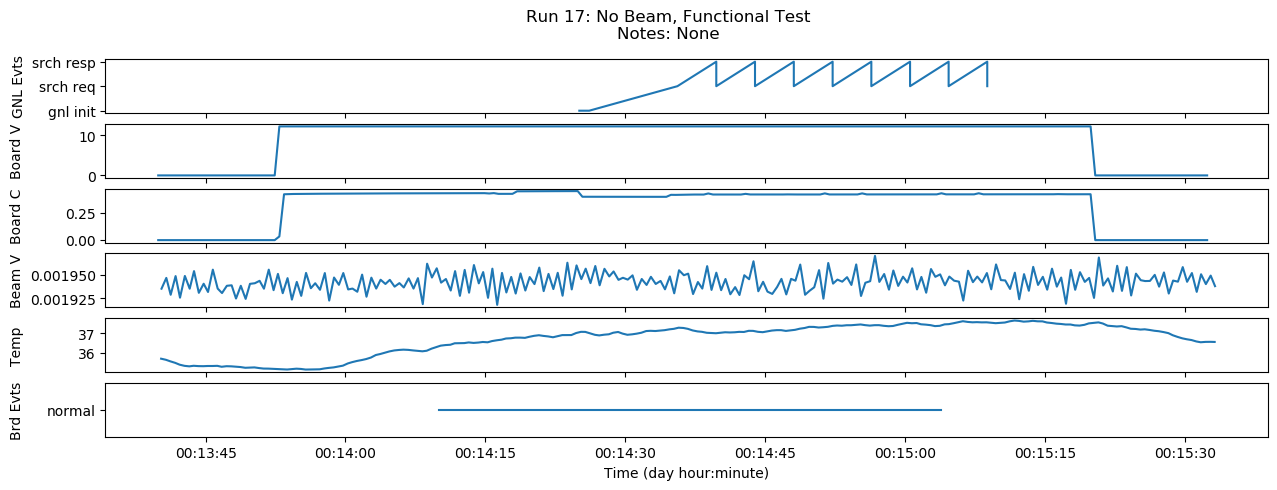

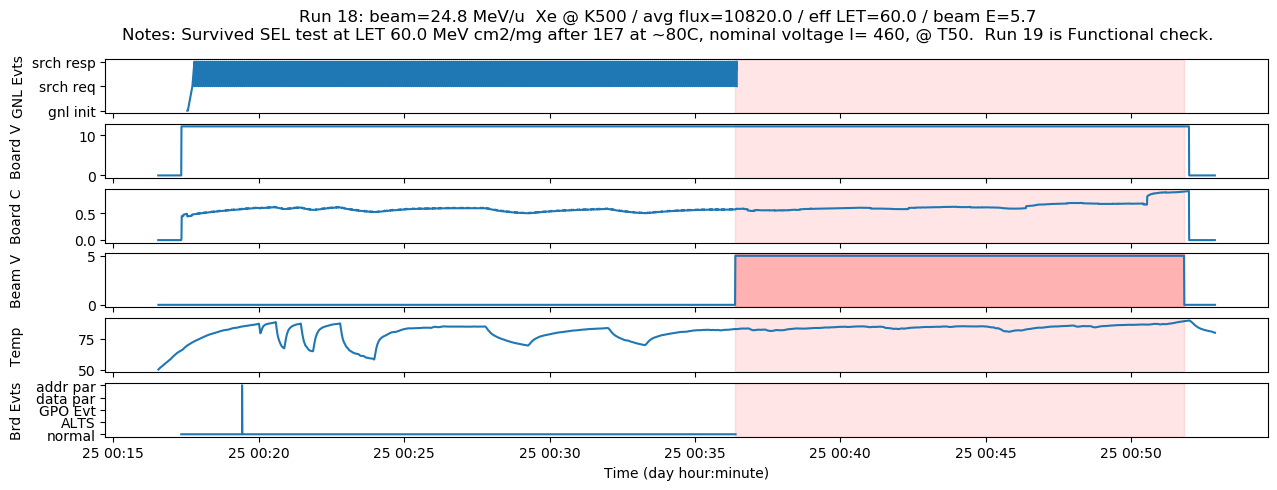

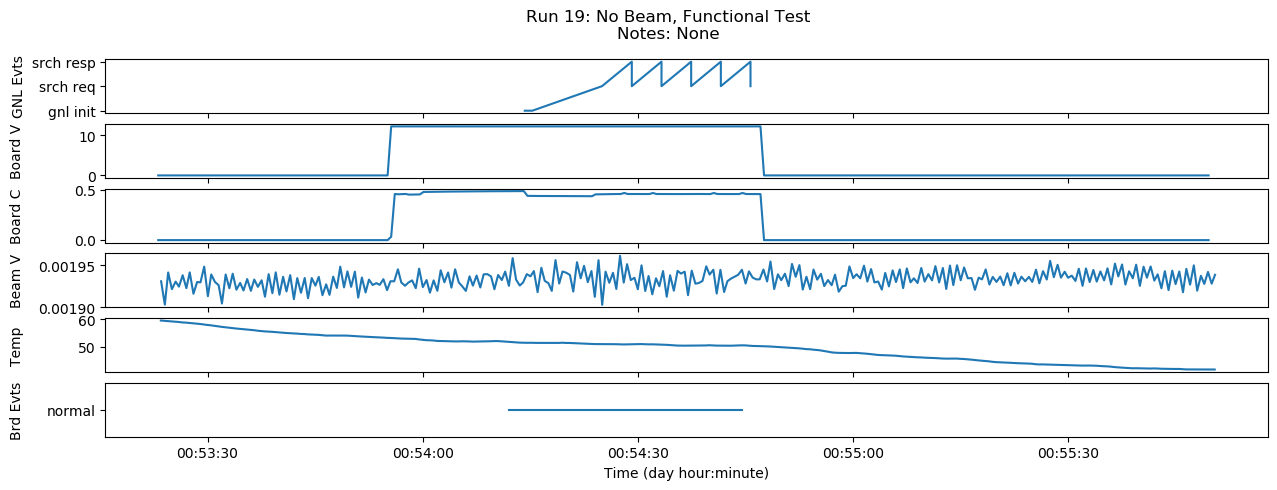

In [133]:
# Plot all the Run graphs

FSIZE = (15,5)

def plot_all( gsi_ts, logs_marker, troxel_ts, voltages, current, \
             troxel_beamvoltages_ts, beam_voltages, troxel_temp_ts, \
             temps, minicom_ts, minicom_markers, fname, subtitle, notes, beam_ons):
    if (gsi_ts ==None ): return
    
    fig, axes = plt.subplots(6,1, sharex = True, figsize=FSIZE,dpi=100) 
    #print(fig, axes)

    axes[5].set_yticks([-1,0,1,2,3])
    axes[5].set_yticklabels(["normal","ALTS","GPO Evt", "data par","addr par"])

    axes[0].set_yticks([-1,0,1])
    axes[0].set_yticklabels(["gnl init","srch req", "srch resp"])
    
    axes[-1].set_xlabel("Time (day hour:minute)")

    axes[0].set_ylabel("GNL Evts")
    axes[1].set_ylabel("Board V")
    axes[2].set_ylabel("Board C")
    axes[3].set_ylabel("Beam V")
    axes[4].set_ylabel("Temp")
    axes[5].set_ylabel("Brd Evts")

    axes[0].plot(gsi_ts, logs_marker)
    axes[1].plot(troxel_ts, voltages)
    axes[2].plot(troxel_ts, current)
    axes[3].plot(troxel_beamvoltages_ts, beam_voltages)
    axes[4].plot(troxel_temp_ts, temps)
    axes[5].plot(minicom_ts, minicom_markers)
    
    if (beam_ons):
        for beam_on in beam_ons:
            x1, x2 = beam_on
            axes[0].axvspan(x1,x2, alpha=0.1, color='red')
            axes[1].axvspan(x1,x2, alpha=0.1, color='red')
            axes[2].axvspan(x1,x2, alpha=0.1, color='red')
            axes[3].axvspan(x1,x2, alpha=0.3, color='red')
            axes[4].axvspan(x1,x2, alpha=0.1, color='red')
            axes[5].axvspan(x1,x2, alpha=0.1, color='red')

    #10 == figsize[0]
    #axes[1].yaxis.set_label_coords(-0.103,0.5)
    #axes[2].yaxis.set_label_coords(-0.103,0.5)

    #15 == figsize[0]
    axes[1].yaxis.set_label_coords(-0.07,0.5)
    axes[2].yaxis.set_label_coords(-0.07,0.5)
    axes[3].yaxis.set_label_coords(-0.07,0.5)
    axes[4].yaxis.set_label_coords(-0.07,0.5)
    axes[5].yaxis.set_label_coords(-0.07,0.5)
 
    fig.suptitle("%s\n%s" % ( "%s: %s" % (fname, subtitle), "Notes: %s" % notes))
    fig.savefig("%s.jpg" % fname,dpi=100,quality=100)
    

for i in range(len(all_dirs)):
    gsi_ts = all_gsi_ts[i]
    logs_marker = all_logs_marker[i]
    troxel_ts = all_troxel_ts[i]
    voltages = all_voltages[i]
    current = all_current[i]
    troxel_beamvoltages_ts = all_troxel_beamvoltages_ts[i]
    beam_voltages = all_beam_voltages[i]
    troxel_temp_ts = all_troxel_temp_ts[i]
    minicom_ts = all_minicom_ts[i]
    minicom_markers = all_minicom_markers[i]
    temps = all_temps[i]
    fname = all_dirs[i][2]
    beam_ons = all_beam_ons[i]
    
    subtitle = "No Beam, Functional Test"
    if ( (i+1) in expdetails.keys() ):
        subtitle = expdetails[i+1]
        
    notes = "None"
    if ( (i+1) in expnotes.keys() ):
        notes = expnotes[i+1]
    
    try:
        plot_all( gsi_ts, logs_marker, troxel_ts, voltages, current, \
             troxel_beamvoltages_ts, beam_voltages, troxel_temp_ts, \
                 temps, minicom_ts, minicom_markers, fname, subtitle,notes, beam_ons )
    except:
        print("Could not plot Run", i+1)